# Operations Demand Planning (Bike Share)

###### Understand product and service usage characteristics based on operational and external information. Predict the likely placement or time a service will be used to optimize revenue. Finally, increase the likelihood of positive sentiments by having the right product available at the right time.

In [2]:
import math
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1 Get the Data

In [3]:
df = pd.read_csv('06 WA_Fn-UseC_-Operations-Dem-Planning_-BikeShare.csv')
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 12 columns):
Instant        17379 non-null int64
Riders         17379 non-null int64
Season         17379 non-null int64
Month          17379 non-null int64
Hour           17379 non-null int64
Holiday        17379 non-null int64
Weekday        17379 non-null int64
Workday        17379 non-null int64
Weather        17379 non-null int64
Temperature    17379 non-null int64
Humidity       17379 non-null float64
Wind           17379 non-null float64
dtypes: float64(2), int64(10)
memory usage: 1.7 MB


In [4]:
def HB (x):
    if (x>=7 and x<=15): return "b. day (7-15)"
    elif (x>=16 and x<=19): return "a. evening (16-19)"
    elif (x>=20 and x<=22): return "c. late evening (20-22)"
    else: return "d. night (23, 0-6)"
df['Hour_bin'] = df['Hour'].apply(HB)

In [5]:
def TB (x):
    if x<45: return "a. temp < 45"
    elif x<60: return "b. temp < 60"
    elif x<75: return "c. temp < 75"
    else: return "d. temp - higher"
df['Temperature_bin'] = df['Temperature'].apply(TB)

In [6]:
def HB (x):
    if x<0.45: return "a. humid < 0.45"
    elif x<0.60: return "b. humid < 0.60"
    elif x<0.75: return "c. humid < 0.75"
    else: return "d. humid - higher"
df['Humidity_bin'] = df['Humidity'].apply(HB)

In [7]:
def SB (x): 
    if x==1: return "a. Jan-Mar"
    elif x==3: return "c. Jul-Aug"
    else: return "b. Others"
df['Season_bin'] = df['Season'].apply(SB)

In [8]:
df = df[['Riders','Hour_bin','Temperature_bin','Humidity_bin','Season_bin','Weather','Holiday']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 7 columns):
Riders             17379 non-null int64
Hour_bin           17379 non-null object
Temperature_bin    17379 non-null object
Humidity_bin       17379 non-null object
Season_bin         17379 non-null object
Weather            17379 non-null int64
Holiday            17379 non-null int64
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


# 2a Hour_bin

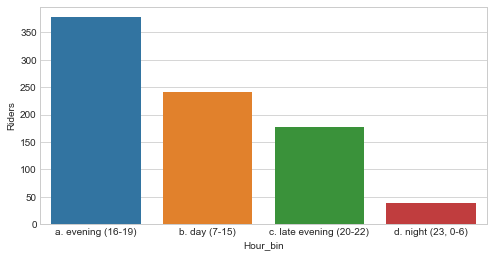

In [9]:
temp = pd.DataFrame(df.groupby(['Hour_bin'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Hour_bin", y="Riders",data=temp)

# 2b Temperature_bin

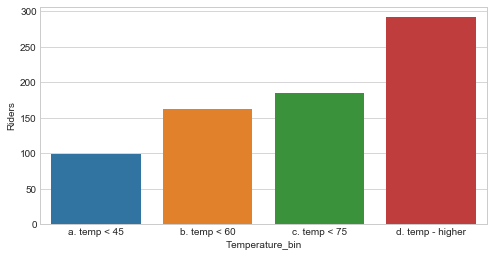

In [10]:
temp = pd.DataFrame(df.groupby(['Temperature_bin'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Temperature_bin", y="Riders",data=temp)

# 2c Humidity_bin

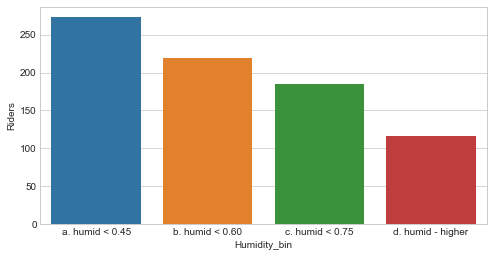

In [11]:
temp = pd.DataFrame(df.groupby(['Humidity_bin'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Humidity_bin", y="Riders",data=temp)

# 2d Season_bin

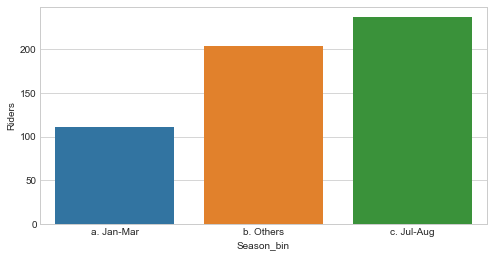

In [12]:
temp = pd.DataFrame(df.groupby(['Season_bin'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Season_bin", y="Riders",data=temp)

# 2e Weather

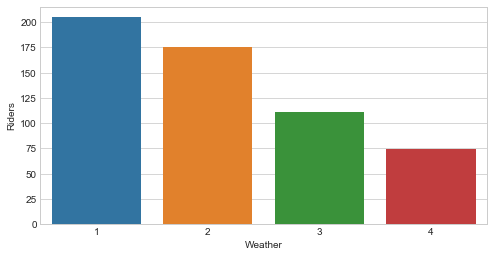

In [13]:
temp = pd.DataFrame(df.groupby(['Weather'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Weather", y="Riders",data=temp)

# 2f Holiday

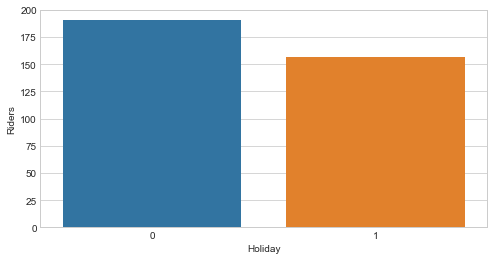

In [14]:
temp = pd.DataFrame(df.groupby(['Holiday'], axis=0, as_index=False)['Riders'].mean())
plt.figure(figsize=(8,4))
sns.barplot(x="Holiday", y="Riders",data=temp)

# 3 Train Test Split

In [15]:
def RB (x):
    if x<50: return "a. 0-50 bikes"
    elif x<=150: return "b. 50-150 bikes"
    elif x<=300: return "c. 150-300- bikes"
    else: return "d. 300+ bikes"
df['actual'] = df['Riders'].apply(RB)

df.drop(['Riders'],axis=1,inplace=True)

In [16]:
cat_feats = ['Hour_bin','Temperature_bin','Humidity_bin','Season_bin','Weather','Holiday']
final_data = pd.get_dummies(df,columns=cat_feats,drop_first=True)

In [17]:
x = final_data.drop(['actual'],axis=1)
y = final_data['actual']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=101)

# 4 Building the Model

###### n_estimaor - number of trees in the forest

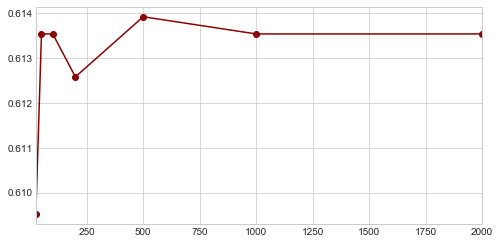

In [18]:
results = []
n_estimaor_options = [25,50,100,200,500,1000,2000]
for trees in n_estimaor_options:
    model = RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=101)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)

plt.figure(figsize=(8,4))
pd.Series(results, n_estimaor_options).plot(color="darkred",marker="o")

###### max_features - number of features considered 
###### auto = None = all features are considered 

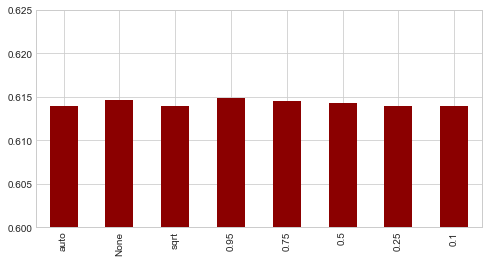

In [19]:
results = []
max_features_options = ['auto',None,'sqrt',0.95,0.75,0.5,0.25,0.10]
for trees in max_features_options:
    model = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=101, max_features = trees)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)

plt.figure(figsize=(8,4))
pd.Series(results, max_features_options).plot(kind="bar",color="darkred",ylim=(0.60,0.625))

###### min_samples_leaf - minimum number of samples in new leaf 
###### sqrt(12165) = 110

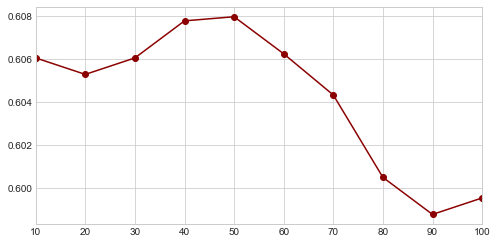

In [20]:
results = []
min_samples_leaf_options = [10,20,30,40,50,60,70,80,90,100]
for trees in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=101, max_features = None, min_samples_leaf = trees)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = np.mean(y_test==y_pred)
    results.append(accuracy)

plt.figure(figsize=(8,4))
pd.Series(results, min_samples_leaf_options).plot(color="darkred",marker="o")

# 5 Predictions and Evaluation

In [21]:
model = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=101, 
                               max_features = None, min_samples_leaf = 50)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=101, verbose=0, warm_start=False)

In [22]:
y_pred = model.predict(x_test)

print('\033[1m' + '\033[4m' + 'accuracy' + '\033[0m')
print(round(np.mean(y_test==y_pred)*100,2),"%")
print('\n')
print('\033[1m' + '\033[4m' + 'classification_report' + '\033[0m')
print(classification_report(y_test,y_pred))
print('\n')
print('\033[1m' + '\033[4m' + 'confusion_matrix' + '\033[0m')
print(confusion_matrix(y_test,y_pred))

accuracy
60.8 %


classification_report
                   precision    recall  f1-score   support

    a. 0-50 bikes       0.73      0.87      0.80      1445
  b. 50-150 bikes       0.51      0.37      0.43      1234
c. 150-300- bikes       0.51      0.61      0.55      1353
    d. 300+ bikes       0.65      0.53      0.58      1182

      avg / total       0.60      0.61      0.60      5214



confusion_matrix
[[1256  135   38   16]
 [ 400  461  283   90]
 [  57  237  826  233]
 [   0   67  488  627]]
